In [1]:
%load_ext autoreload
%autoreload 1

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from lightgbm import LGBMClassifier
import gc
import os
import re
import json

%aimport src.utils
%aimport src.feats

import src.utils as utils
import src.feats as feats



# %afrom src.utils import utils
# %afrom src.feats import feats

In [3]:
 train = utils.read_csv('./input/application_train.csv')
 test = utils.read_csv('./input/application_test.csv')
 prev = utils.read_csv('./input/previous_application.csv')
 buro = utils.read_csv('./input/bureau.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [4]:
feats.append_features(train)
feats.append_features(test)

In [5]:
categorical_feats = [
    f for f in train.columns if train[f].dtype == 'object'
]

In [6]:
for f in categorical_feats:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [7]:
gc.enable()

In [8]:
y = train['TARGET']
del train['TARGET']

In [9]:
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

In [10]:
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

In [11]:
buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
for f_ in buro_cat_features:
    buro[f_], _ = pd.factorize(buro[f_])

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

In [12]:
train = train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')


In [13]:
excluded_feats = ['SK_ID_CURR', 'HOUR_APPR_PROCESS_START']
excluded_feats = sum(list(map(lambda c: [c, f"{c}_x", f"{c}_y"], excluded_feats)), [])
features = [f_ for f_ in train.columns if f_ not in excluded_feats]
features

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG'

In [14]:
trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=42)

In [16]:
params = {
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'num_leaves': 63,
    'colsample_bytree': .8,
    'subsample': .8,
    'subsample_freq': 5,
    'max_depth': 5,
    'reg_alpha': .001,
    'reg_lambda': .1,
    'min_split_gain': .01,
    'device': "gpu",
#     'categorical_feature': 'name:CODE_GENDER'
}


clf = LGBMClassifier(**params)

eval_set = [(trn_x, trn_y), (val_x, val_y)]

%time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
test_preds = clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

trn_auc = roc_auc_score(trn_y, trn_preds)
auc = roc_auc_score(val_y, val_preds)
print('AUC : %.6f' % auc)
gc.collect()

config = {
    'model': 'lgbm',
    'params': params,
    'trn_auc': trn_auc,
    'auc': auc,
    'features': features
}

Training until validation scores don't improve for 150 rounds.
[250]	training's auc: 0.768619	valid_1's auc: 0.755129
[500]	training's auc: 0.789425	valid_1's auc: 0.767517
[750]	training's auc: 0.80207	valid_1's auc: 0.772813
[1000]	training's auc: 0.811519	valid_1's auc: 0.775521
[1250]	training's auc: 0.819666	valid_1's auc: 0.77722
[1500]	training's auc: 0.827605	valid_1's auc: 0.778642
[1750]	training's auc: 0.834783	valid_1's auc: 0.779614
[2000]	training's auc: 0.841308	valid_1's auc: 0.780406
[2250]	training's auc: 0.84656	valid_1's auc: 0.78077
[2500]	training's auc: 0.852148	valid_1's auc: 0.781095
[2750]	training's auc: 0.857577	valid_1's auc: 0.781443
[3000]	training's auc: 0.862831	valid_1's auc: 0.781752
Early stopping, best iteration is:
[2996]	training's auc: 0.862715	valid_1's auc: 0.781768
CPU times: user 21min 39s, sys: 1min 45s, total: 23min 25s
Wall time: 6min 20s
AUC : 0.781768


In [17]:
utils.save_result(
    test=test,
    test_preds=test_preds,
    config=config,
)

Save to ./experiments/015-lgbm-0.781768.csv


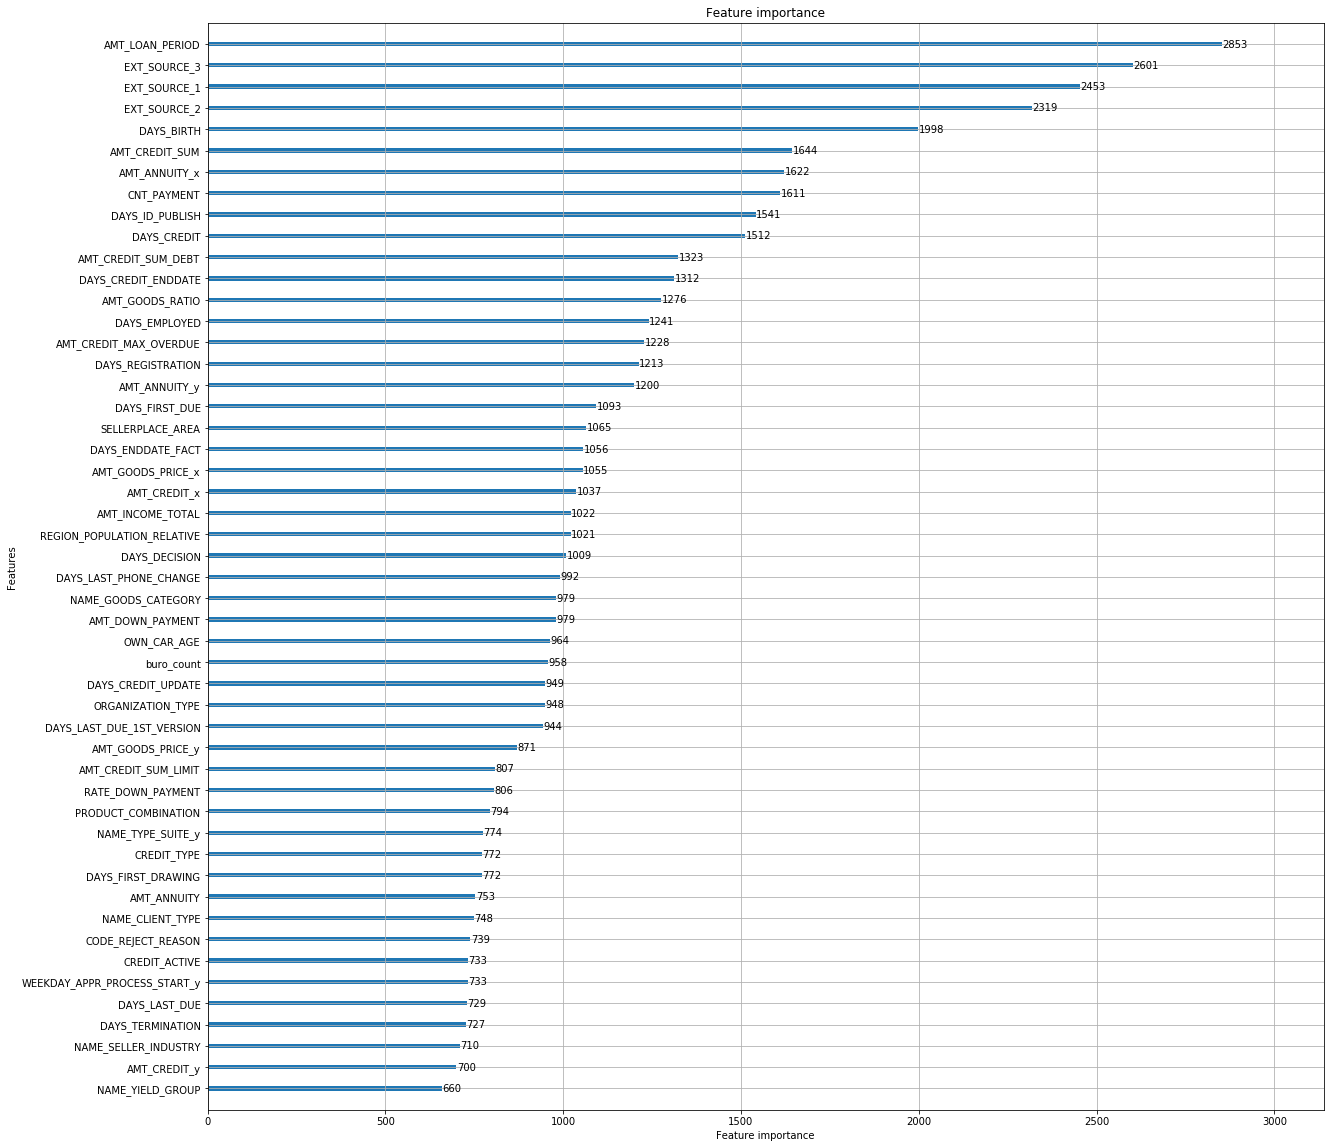

In [32]:
import lightgbm.plotting

lightgbm.plotting.plot_importance(clf, max_num_features=50, figsize=(20, 20))